<a href="https://colab.research.google.com/github/AngelRosalesContreras/Practica_1-3/blob/main/Practica_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 1.3 (Transformada de Hough y Etiquetado de componentes conectados)**

Ponemos las librerias necesarias

In [17]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

Desarrollamos Canny

In [2]:
# Función para aplicar Canny
def canny_edge_detection(image, low_threshold, high_threshold):
    # Convertir la imagen a escala de grises
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar el filtro de Sobel para encontrar gradientes en la imagen
    sobel_x = cv2.Sobel(grayscale_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(grayscale_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular la magnitud del gradiente
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Calcular la dirección del gradiente
    gradient_direction = np.arctan2(sobel_y, sobel_x)

    # Aplicar la supresión de no máximos
    suppressed_gradient = np.zeros_like(gradient_magnitude)
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            angle = gradient_direction[i, j]
            if (angle >= 0 and angle <= np.pi / 4) or (angle >= 7 * np.pi / 4 and angle <= 2 * np.pi):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i, j - 1] and
                    gradient_magnitude[i, j] >= gradient_magnitude[i, j + 1]):
                    suppressed_gradient[i, j] = gradient_magnitude[i, j]
            elif (angle >= np.pi / 4 and angle <= 3 * np.pi / 4):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j - 1] and
                    gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j + 1]):
                    suppressed_gradient[i, j] = gradient_magnitude[i, j]
            elif (angle >= 3 * np.pi / 4 and angle <= 5 * np.pi / 4):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j] and
                    gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j]):
                    suppressed_gradient[i, j] = gradient_magnitude[i, j]
            else:
                if (gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j + 1] and
                    gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j - 1]):
                    suppressed_gradient[i, j] = gradient_magnitude[i, j]

    # Aplicar la binarización con histéresis (Canny)
    high_threshold = np.max(suppressed_gradient) * high_threshold
    low_threshold = high_threshold * low_threshold

    # Crear una imagen de bordes final
    edge_image = np.zeros_like(suppressed_gradient, dtype=np.uint8)
    strong_edge_i, strong_edge_j = np.where(suppressed_gradient >= high_threshold)
    weak_edge_i, weak_edge_j = np.where((suppressed_gradient >= low_threshold) &
                                        (suppressed_gradient < high_threshold))

    edge_image[strong_edge_i, strong_edge_j] = 255
    edge_image[weak_edge_i, weak_edge_j] = 50  # Valor intermedio para bordes débiles

    return edge_image

Desarrollamos la Transformada de Hough

In [3]:
# Función para aplicar la Transformada de Hough
def hough_transform(edge_image, theta_resolution=1, rho_resolution=1):
    height, width = edge_image.shape
    max_rho = int(np.sqrt(height**2 + width**2))

    # Rango de valores de theta
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # Matriz acumuladora para la Transformada de Hough
    accumulator = np.zeros((2 * max_rho, len(thetas)), dtype=np.uint64)

    # Obtener las coordenadas de los bordes detectados
    edge_coordinates = np.argwhere(edge_image > 0)

    for i in range(len(edge_coordinates)):
        y, x = edge_coordinates[i]
        for t_index in range(len(thetas)):
            rho = int(x * np.cos(thetas[t_index]) + y * np.sin(thetas[t_index]))
            rho_index = rho + max_rho
            accumulator[rho_index, t_index] += 1

    return accumulator, thetas

Cargamos la imagen

In [4]:
# Cargar la imagen
image = cv2.imread('um_000002.png')

Aplicamos Canny a la imagen

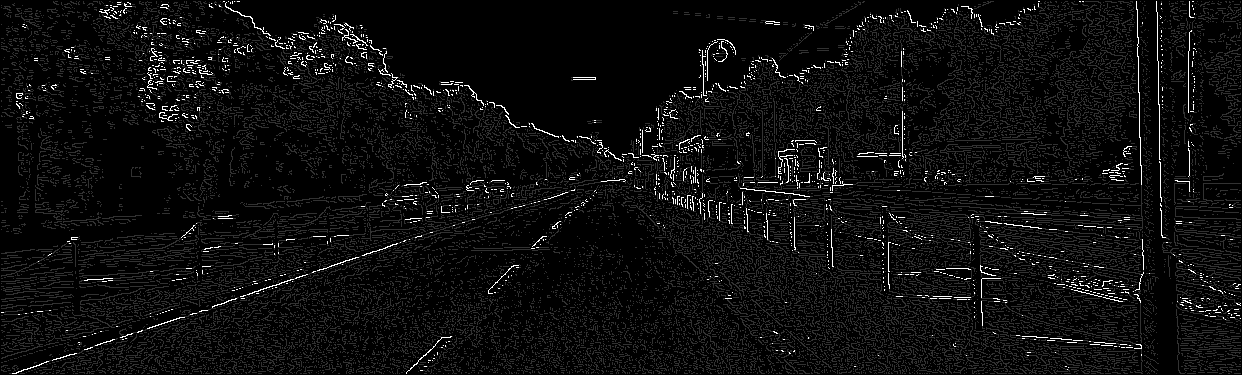

In [5]:
# Aplicar Canny para detectar bordes
canny_image = canny_edge_detection(image, low_threshold=0.1, high_threshold=0.3)

# Mostrar la imagen con bordes detectados
cv2_imshow(canny_image)

Aplicamos Hough

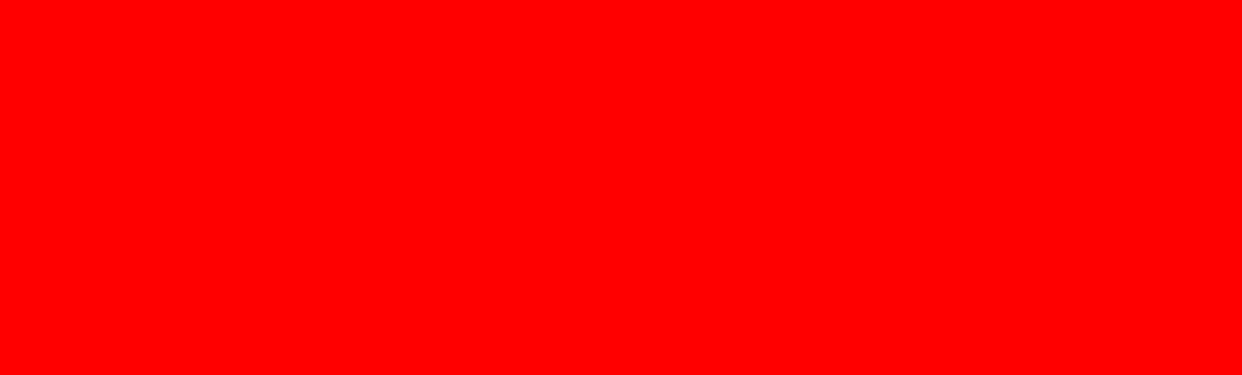

In [21]:
# Aplicar la Transformada de Hough para detectar líneas rectas
lines = cv2.HoughLines(canny_image, rho=1, theta=np.pi / 180, threshold=100)

# Dibujar las líneas detectadas en una copia de la imagen original
image_with_lines = np.copy(image)

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Mostrar la imagen con las líneas detectadas
cv2_imshow(image_with_lines)



In [ ]:
print()